In [2]:
import os
import pathlib
import numpy as np
import pandas as dp
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import cv2
import PIL.Image as Image
import pathlib

In [3]:
direct="D:\CloudComputing_Rice_Type_Classification\Rice_Type_Classification\Rice_Image_Dataset"
direct=pathlib.Path(direct)
direct

WindowsPath('D:/CloudComputing_Rice_Type_Classification/Rice_Type_Classification/Rice_Image_Dataset')

In [4]:
arborio = list(direct.glob('Arborio/*'))[:500]
basmati = list(direct.glob('Basmati/*'))[:500]
ipsala = list(direct.glob('Ipsala/*'))[:500]
jasmine = list(direct.glob('Jasmine/*'))[:500]
karacadag = list(direct.glob('Karacadag/*'))[:500]

In [5]:
rice_names = { 'arborio' : arborio, 'basmati' : basmati, 'ipsala' : ipsala, 'jasmine' : jasmine, 'karacadag': karacadag }

In [6]:
rice_index = { 'arborio' : 0, 'basmati' : 1, 'ipsala' : 2, 'jasmine' : 3, 'karacadag': 4 }

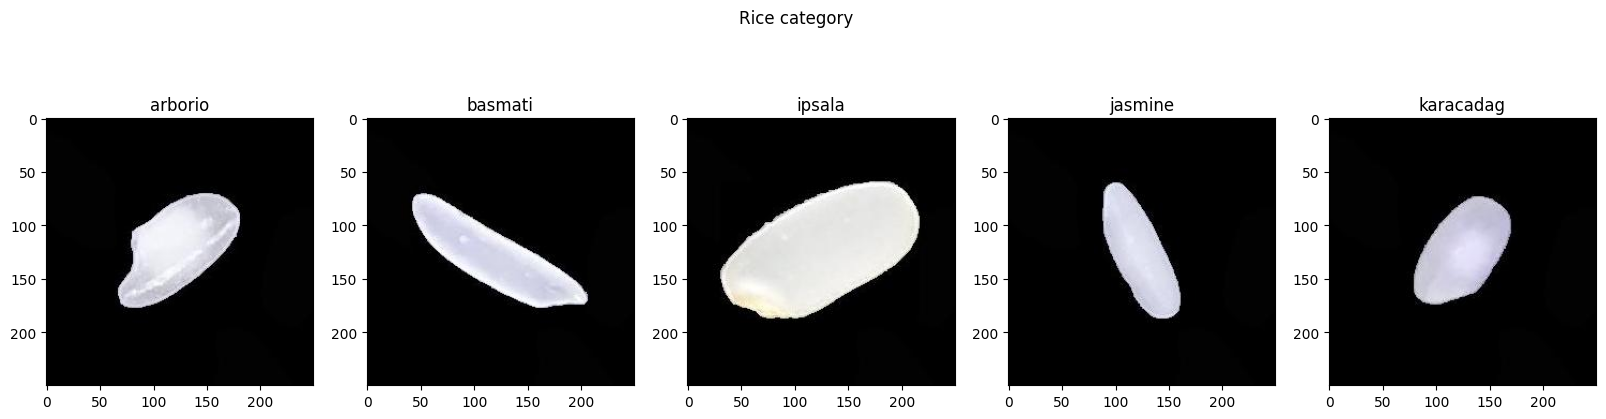

In [14]:
fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice category')
arborio_image = plt.imread(arborio[0])
basmati_image = plt.imread(basmati[0])
ipsala_image = plt.imread(ipsala[0])
jasmine_image = plt.imread(jasmine[0])
karacadag_image = plt.imread(karacadag[0])

ax[0].set_title('arborio')
ax[1].set_title('basmati')
ax[2].set_title('ipsala')
ax[3].set_title('jasmine')
ax[4].set_title('karacadag')

ax[0].imshow(arborio_image)
ax[1].imshow(basmati_image)
ax[2].imshow(ipsala_image)
ax[3].imshow(jasmine_image)
ax[4].imshow(karacadag_image)


Pre-trained CNN Model

In [4]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2

# Global class mapping
class_mapping = {'arborio': 0, 'basmati': 1, 'ipsala': 2, 'jasmine': 3, 'karacadag': 4}

# Function to load and preprocess rice images from dataset
def load_rice_data(data_path, img_size=(224, 224)):
    images = []
    labels = []

    # Loop through each class directory to load images and assign labels
    for class_name, class_idx in class_mapping.items():
        class_dir = os.path.join(data_path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(class_idx)

    # Convert lists to NumPy arrays and normalize pixel values
    images = np.array(images) / 255.0
    labels = np.array(labels)
    return images, labels

# Function to assign fluid behavior (0 = sink, 1 = float) to each sample
def assign_fluid_behavior(n_samples):
    return np.random.randint(0, 2, size=n_samples)

# Function to create data generators
def create_data_generators(data_path, img_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

    # Training generator
    train_generator = datagen.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='training'
    )

    # Validation generator
    validation_generator = datagen.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='validation'
    )

    return train_generator, validation_generator

# Load data generators
data_path = r"D:\CloudComputing_Rice_Type_Classification\Rice_Type_Classification\Rice_Image_Dataset"  # Update this path
train_generator, val_generator = create_data_generators(data_path)

# Build the model with two inputs: image and fluid behavior
image_input = Input(shape=(224, 224, 3), name="image_input")
fluid_input = Input(shape=(1,), name="fluid_input")

# Use MobileNetV2 as the base model for image feature extraction
base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224, 224, 3))
x = base_model(image_input)
x = Flatten()(x)

# Concatenate image features with fluid behavior input
combined = Concatenate()([x, fluid_input])

# Add dense layers for classification
dense1 = Dense(128, activation='relu')(combined)
output = Dense(len(class_mapping), activation='softmax')(dense1)  # Update to use the length of class_mapping

# Define and compile the model
model = Model(inputs=[image_input, fluid_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Create a generator function to combine image data with fluid behavior
def generator_with_fluid(generator):
    while True:
        x, y = next(generator)
        fluid_labels = assign_fluid_behavior(len(x))  # Generate fluid behavior labels on the fly
        yield [x, fluid_labels], y

# Create training and validation generators
train_gen_with_fluid = generator_with_fluid(train_generator)
val_gen_with_fluid = generator_with_fluid(val_generator)

# Train the model
history = model.fit(
    train_gen_with_fluid,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_gen_with_fluid,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=5
)

# Save the trained model
model.save('rice_type_classification_with_fluid_mechanics.h5')

print("Training completed and model saved.")



Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['image_input[0][0]']         
 tional)                                                                                          
                                                                                                  
 flatten_6 (Flatten)         (None, 62720)                0         ['mobilenetv2_1.00_224[0][0]']
                                                                                                  
 fluid

d:\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training completed and model saved.


In [26]:
model.save('rice_type_classification_with_fluid_mechanics.h5')